# Notebook for make a modeling focus in reduce churn rate in Telco SA

## Libs

In [1]:
import pandas as pd
import numpy as np
import joblib
import pickle

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC

from lazypredict.Supervised import LazyClassifier


## Load - train and valid data

In [2]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

In [3]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_valid.pkl', 'rb') as f:
    X_valid = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_valid.pkl', 'rb') as f:
    y_valid = pickle.load(f)

## Overview train

In [4]:
X_train.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
0151-ONTOV,Female,No,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.90,70.90
6551-ZCOTS,Male,Yes,No,No,33,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),24.90,847.80


In [5]:
y_train.head()

customerID
0151-ONTOV    Yes
6551-ZCOTS     No
4423-YLHDV    Yes
0784-ZQJZX     No
6424-ELEYH    Yes
Name: Churn, dtype: object

## Overview valid

In [6]:
X_valid.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
6689-KXGBO,Female,No,No,No,1,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,50.55,50.55
8402-OOOHJ,Female,No,No,No,41,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.65,835.15


In [7]:
y_valid.head()

customerID
6689-KXGBO    Yes
8402-OOOHJ     No
4355-HBJHH    Yes
3638-VBZTA     No
9770-KXGQU     No
Name: Churn, dtype: object

## Feature Transform
- Used LabelEncoder in all categorical columns because not ordenal categories

In [8]:
cat_cols = X_train.select_dtypes(include=['object']).columns

In [9]:
cat_cols

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [10]:
num_cols = X_train.select_dtypes(include=['number']).columns

In [11]:
num_cols

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

- X Label Encoder

In [12]:
le_X = LabelEncoder()
X_train[cat_cols] = X_train[cat_cols].apply(lambda col: le_X.fit_transform(col))
X_valid[cat_cols] = X_valid[cat_cols].apply(lambda col: le_X.fit_transform(col))

- X MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
# fit scaler on the training dataset
scaler.fit(X_train[num_cols])
# transform the training dataset
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])

- Y Label Encoder

In [16]:
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)

## Sanity check - Encoders data
- Churn (Yes) == 1
- Churn (No) == 0

In [17]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
0151-ONTOV,0,0,0,0,0.01,1,0,1,0,0,0,0,0,0,0,0,3,0.52,0.01
6551-ZCOTS,1,1,0,0,0.46,1,2,2,1,1,1,1,1,1,1,1,0,0.07,0.10
4423-YLHDV,0,0,1,0,0.29,1,2,1,2,0,2,0,2,2,0,1,0,0.86,0.25
0784-ZQJZX,1,0,0,1,1.00,1,0,2,1,1,1,1,1,1,2,0,1,0.02,0.18
6424-ELEYH,0,0,1,0,0.04,1,2,1,0,0,0,0,0,0,0,1,1,0.56,0.03


In [18]:
X_valid.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
6689-KXGBO,0,0,0,0,0.01,1,0,0,0,2,0,0,0,0,0,0,2,0.32,0.01
8402-OOOHJ,0,0,0,0,0.57,1,0,2,1,1,1,1,1,1,2,0,3,0.02,0.10
4355-HBJHH,1,0,1,1,0.93,1,2,0,2,0,2,0,2,2,2,1,2,0.61,0.61
3638-VBZTA,1,0,0,1,0.94,1,2,0,2,2,0,2,2,2,2,1,0,0.68,0.68
9770-KXGQU,0,0,0,0,0.74,1,2,1,2,2,2,0,2,0,1,0,3,0.80,0.61


In [19]:
y_train[:5]

array([1, 0, 1, 0, 1])

In [20]:
y_valid[:5]

array([1, 0, 1, 0, 0])

## Testing models - V1
- Using Auto-ML

In [21]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:08<00:00,  3.38it/s]


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.79,0.79,0.79,0.80,0.02
BernoulliNB,0.78,0.77,0.77,0.79,0.01
GaussianNB,0.78,0.77,0.77,0.79,0.01
SGDClassifier,0.83,0.75,0.75,0.83,0.04
AdaBoostClassifier,0.83,0.75,0.75,0.82,0.23
NearestCentroid,0.72,0.75,0.75,0.73,0.01
LogisticRegression,0.83,0.74,0.74,0.82,0.04
LinearSVC,0.83,0.73,0.73,0.82,0.15
LinearDiscriminantAnalysis,0.82,0.73,0.73,0.81,0.03


## Feature Selection
- based with 
- Select LogisticRegression based first better F1 Score

In [22]:
# feature selection - usar essa função “elimina” os recursos com maior probabilidade de serem independentes da classe e, portanto, irrelevantes para a classificação.
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [23]:
# feature selection
X_train_fs, X_valid_fs, fs = select_features(X_train, y_train, X_valid)

In [24]:
# what are scores for the features
for i, score in enumerate(fs.scores_):
    print(f'Feature {i}: {score}')

Feature 0: 0.11425957255147143
Feature 1: 98.56714078503734
Feature 2: 68.24846250761757
Feature 3: 99.76023176206076
Feature 4: 177.94514451744186
Feature 5: 0.10825028625527677
Feature 6: 8.477354257466914
Feature 7: 5.539512749772303
Feature 8: 441.4130198017487
Feature 9: 165.20163895679985
Feature 10: 138.60220971728967
Feature 11: 433.95366444291847
Feature 12: 5.4667414005119594
Feature 13: 4.48131424826182
Feature 14: 889.5446350428857
Feature 15: 83.67120964565714
Feature 16: 48.895654336643766
Feature 17: 41.99587886397272
Feature 18: 54.56958124594066


In [25]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
0151-ONTOV,0,0,0,0,0.01,1,0,1,0,0,0,0,0,0,0,0,3,0.52,0.01
6551-ZCOTS,1,1,0,0,0.46,1,2,2,1,1,1,1,1,1,1,1,0,0.07,0.10
4423-YLHDV,0,0,1,0,0.29,1,2,1,2,0,2,0,2,2,0,1,0,0.86,0.25
0784-ZQJZX,1,0,0,1,1.00,1,0,2,1,1,1,1,1,1,2,0,1,0.02,0.18
6424-ELEYH,0,0,1,0,0.04,1,2,1,0,0,0,0,0,0,0,1,1,0.56,0.03


- Features to remove because feature selection
    - gender
    - PhoneService

In [26]:
X_train = X_train.drop(['gender','PhoneService'], axis=1)

In [27]:
X_valid = X_valid.drop(['gender','PhoneService'], axis=1)

## Testing models - V2

In [28]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

100%|██████████| 29/29 [00:08<00:00,  3.51it/s]


In [29]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
QuadraticDiscriminantAnalysis,0.78,0.78,0.78,0.79,0.02
BernoulliNB,0.79,0.77,0.77,0.79,0.02
GaussianNB,0.77,0.76,0.76,0.78,0.01
LogisticRegression,0.83,0.76,0.76,0.83,0.03
NearestCentroid,0.72,0.75,0.75,0.73,0.02
LinearDiscriminantAnalysis,0.82,0.74,0.74,0.82,0.03
AdaBoostClassifier,0.82,0.74,0.74,0.82,0.23
LinearSVC,0.83,0.74,0.74,0.82,0.16
CalibratedClassifierCV,0.83,0.74,0.74,0.82,0.72


## Select and train a model - based F1 Score
- Select LogisticRegression based first better F1 Score

In [30]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

## Eval model valid set - V1

In [31]:
def eval_model(clf, X_valid, y_valid):
    y_pred = clf.predict(X_valid)
    
    return print(f'Model: {clf}\n {classification_report(y_valid, y_pred)} ')

In [32]:
eval_model(clf, X_valid, y_valid)

Model: LogisticRegression(class_weight='balanced')
               precision    recall  f1-score   support

           0       0.93      0.73      0.82       528
           1       0.51      0.84      0.63       176

    accuracy                           0.76       704
   macro avg       0.72      0.78      0.73       704
weighted avg       0.82      0.76      0.77       704
 


### Use cross validation eval model

In [33]:
# Instaciando a classe do modelo  
Logit = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")
 
# Treina os modelos 
Logit.fit(X_train, y_train)
        
# Faz predições
y_pred = Logit.predict(X_valid)
 
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Validação cruzada pela métrica f1_score, (nos dados de validação/teste) 
recall = cross_val_score(Logit, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
 
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_valid, y_pred)
 
#Exibe as métricas 
print(f"{Logit}",end="\n\n")
print(f"recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n\n")

LogisticRegression(C=0.1, class_weight='balanced', max_iter=300,
                   random_state=42)

recall_CV:0.800 STD: 0.07, AUC: 0.783



- The results of recall is very good for cross validation ! 

### Visualize eval model

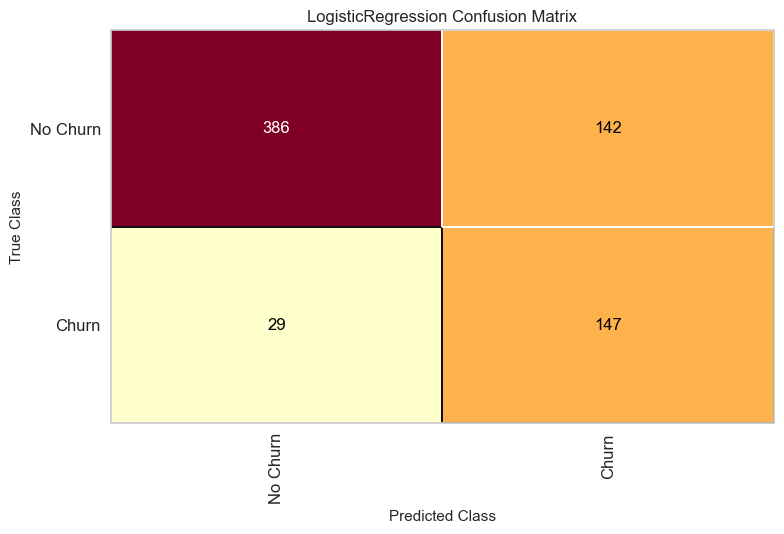

<Figure size 800x550 with 0 Axes>

In [34]:
mapping = {0:"No Churn",1:"Churn"}

confusion_matrix(
    Logit,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

- The model correctly predicts Churn 83.52% of the time !

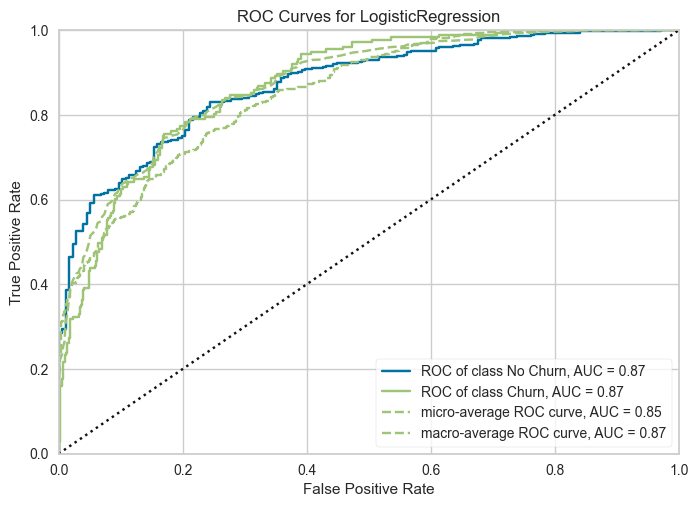

In [35]:
visualizer = ROCAUC(Logit, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

- Good results for ROC AUC !

## Feature Engineering
- In the future = V2 modeling...

## Optmize model
- Use GridSearch

In [36]:
def optmize_model(clf, X_train, y_train, params, cv, X_valid):

    grid_search = GridSearchCV(clf, params, cv=cv)
    grid_search.fit(X_train, y_train)

    print(f'Best params: {grid_search.best_params_}')
    print(f'Best Score: {grid_search.best_score_}')

    return None


In [37]:
log_reg = LogisticRegression()

In [38]:
params = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

In [39]:
optmize_model(clf=log_reg, X_train=X_train, y_train=y_train, params=params, cv=10, X_valid=X_valid)

Best params: {'C': 10, 'penalty': 'l2'}
Best Score: 0.7985447136036683


## Eval model valid set - V2

In [40]:
log_reg = LogisticRegression(class_weight='balanced',
                            random_state=42,
                            C=10, 
                            penalty='l2')

In [41]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=42)

In [42]:
eval_model(log_reg, X_valid, y_valid)

Model: LogisticRegression(C=10, class_weight='balanced', random_state=42)
               precision    recall  f1-score   support

           0       0.93      0.73      0.81       528
           1       0.50      0.82      0.62       176

    accuracy                           0.75       704
   macro avg       0.71      0.78      0.72       704
weighted avg       0.82      0.75      0.77       704
 


In [43]:
# Faz predições
y_pred = log_reg.predict(X_valid)
 
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        
# Validação cruzada pela métrica f1_score, (nos dados de validação/teste) 
recall = cross_val_score(log_reg, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
 
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_valid, y_pred)
 
#Exibe as métricas 
print(f"{log_reg}",end="\n\n")
print(f"recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n\n")

LogisticRegression(C=10, class_weight='balanced', random_state=42)

recall_CV:0.811 STD: 0.07, AUC: 0.776



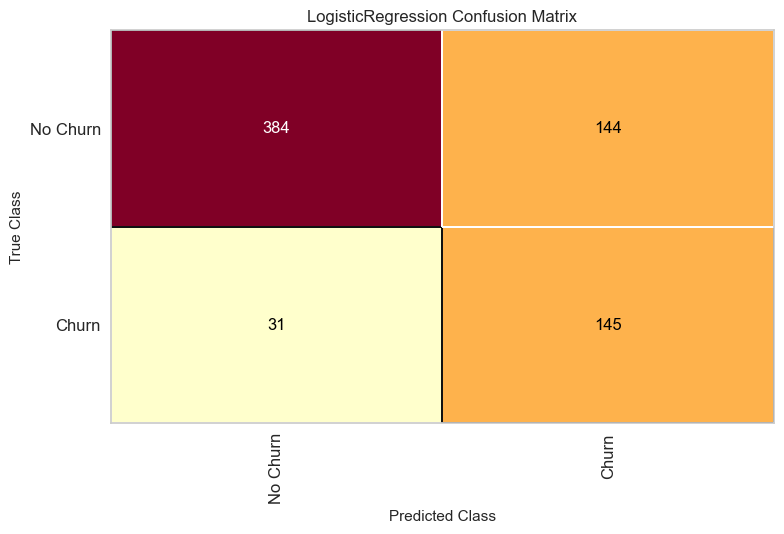

<Figure size 800x550 with 0 Axes>

In [44]:
mapping = {0:"No Churn",1:"Churn"}

confusion_matrix(
    log_reg,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

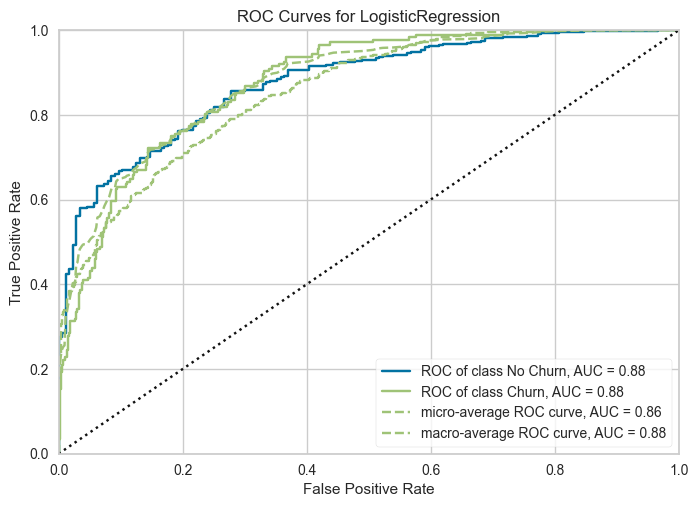

In [45]:
visualizer = ROCAUC(log_reg, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## ``Select the first LogisticRegression (Logit) because is best``

## Model eval test set - V1

In [46]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\data\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [47]:
y_test = le_Y.transform(y_test)

In [50]:
X_test[cat_cols] = X_test[cat_cols].apply(lambda col: le_X.fit_transform(col))

In [52]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [53]:
X_test.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,,,
6284-KMNUF,0,0,1,0,0.78,1,2,1,2,0,0,0,2,2,1,1,2,0.79,0.61
7993-PYKOF,1,0,1,0,0.11,1,0,1,2,0,0,0,0,0,0,0,2,0.56,0.07


In [54]:
y_test[0:5]

array([0, 1, 0, 1, 0])

In [55]:
X_test = X_test.drop(['gender','PhoneService'], axis=1)

In [56]:
eval_model(Logit, X_test, y_test)

Model: LogisticRegression(C=0.1, class_weight='balanced', max_iter=300,
                   random_state=42)
               precision    recall  f1-score   support

           0       0.91      0.72      0.81       519
           1       0.51      0.80      0.62       186

    accuracy                           0.74       705
   macro avg       0.71      0.76      0.71       705
weighted avg       0.80      0.74      0.76       705
 


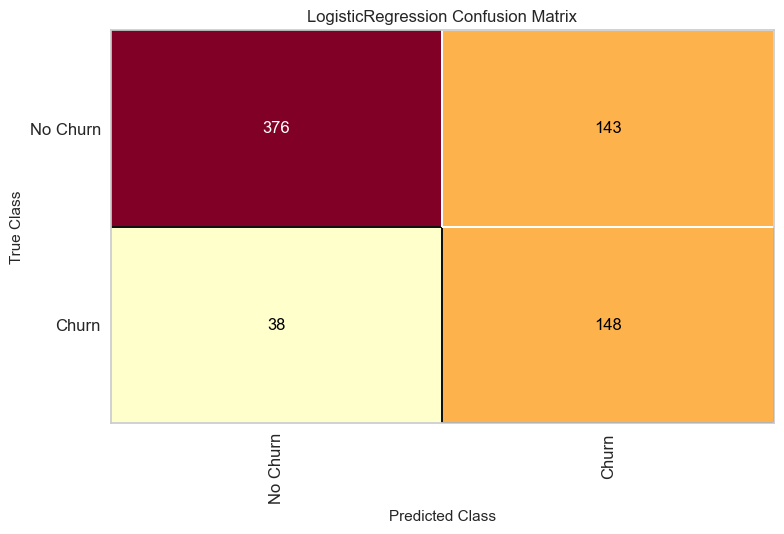

<Figure size 800x550 with 0 Axes>

In [57]:
mapping = {0:"No Churn",1:"Churn"}

confusion_matrix(
    Logit,
    X_valid, y_valid, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

- Great job, identify 79,57% of Churn in the test set !
- Is low if compare with the valid set but is a good result for the test predictions.

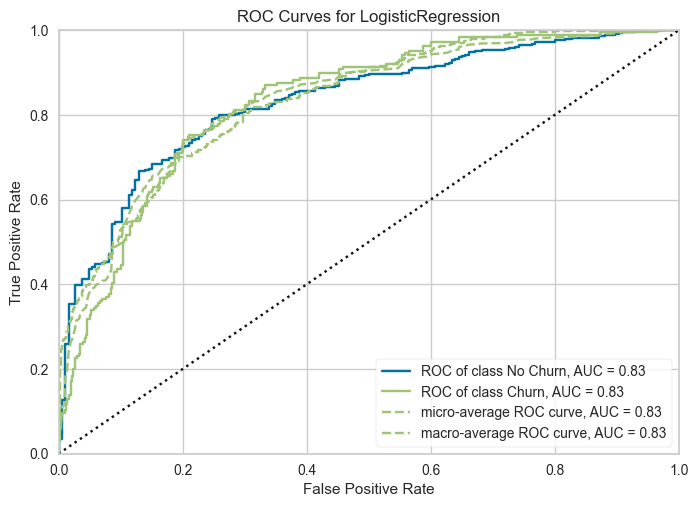

In [58]:
visualizer = ROCAUC(Logit, classes=["No Churn", "Churn"])
visualizer.fit(X_valid, y_valid)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Business performance based on test predicts

- A test sample of 186 customers in Churn was predicted by the model. Of these 186, 148 were correctly predicted (79,57%).

- 1869 customers in Churn implies a shortfall of R$ 200.000,00.
    - (BRL 200.000,00 / 1869) = each customer in Churn costs BRL 107,00

- 186 customers in Churn represent how many reais out of 1869 for the shortfall of R$ 200.000.00?
    - If each customer in Churn costs BRL 107.00 then:
    - (BRL 107,00 * 186) = 186 customers in Churn represent BRL 19,902.00 of the total shortfall

- 148 customers in Churn represent how many reais out of 186?
    - If 186 customers in Churn represent BRL 19.902,00 of the total deficit, then:
    - (BRL 107,00 * 148) = 155 customers in Churn represent BRL 15.836,00 out of 186.

- Soon the financial impact dealing with the test would be a reduction in the real value of the 199 customers in Churn minus the hits of the 155 predicted correctly then:
    - (BRL 19.902,00 - BRL 15.836,00) = BRL 4.066,00
    - For every 186 customers in Churn, we were able to correctly predict that 148 (77.89%) will leave the company or stop buying our products.
    - With that, instead of losing R$ 19.902,00 of capital, we lost only R$ 15.836,00.
    - Decreasing our costs by around BRL 4.066,00 with each iteration of forecasts!

- But this measures the direct impact without the effort with possible new campaigns for customer retention.

- When the campaigns are adjusted according to the customer's profile, then it will be possible to measure the ROI with the continuity of customers actively in Telco SA.

## Deploy

In [59]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
    model = joblib.dump(Logit, f)

In [60]:
with open(r'C:\Users\erico\Documents\projeto-churn\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
    model = joblib.load(f)

In [61]:
model

LogisticRegression(C=0.1, class_weight='balanced', max_iter=300,
                   random_state=42)